Our goal is to understand whether our data has changed changed over time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

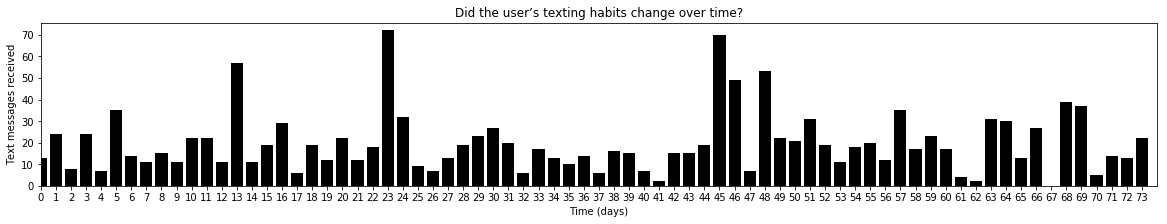

In [2]:
count_data = np.loadtxt("Data/txtdata.csv")
n_count_data = len(count_data)
f, ax = plt.subplots(figsize=(20, 3))
sns.barplot(np.arange(n_count_data), count_data, color = 'black');
plt.xlabel("Time (days)")
plt.ylabel("Text messages received")
plt.title("Did the user’s texting habits change over time?")
plt.xlim(0, n_count_data);

How can we model this data? Well one of the choices we have is the use of using a Poisson model. Why? Becuase this type of model works well with count data. 

$$C_i \text{~} Poi(\lambda)$$

For representation of our model lets assume that $\lambda$ will change after a point of time(t) in our data set $\tau$.

$$
\lambda = 
\begin{cases} 
      \lambda_1 & t < \tau \\
      \lambda_2 & t\geq \tau 
   \end{cases}
$$

The next puzzle to be solved is how do we estimate $\lambda$? The model assumptions state that $\lambda$ can take the form of any positive number. An exponential distribution provides a continuous density function, but the exponential distribution has its own parameters called $\alpha$. So....

$$
\lambda_i \text{~} Exp(\alpha)
$$


"When a random variable Z has an exponential distribution with parameter λ, we say Z is exponential and write Z ∼ Exp(λ) Given a specific λ, the expected value of an exponential random variable is equal to the
inverse of λ. That is,E[Z|λ] = $\frac{1}{λ}$" (Bayesian Methods for Hackers, Cameron Davidson)


Set $\alpha$ as the inverse of the average of the count data, based on the concept above.

$$\frac{1}{N}\sum_{\text{i=0}}^{N}C_i = E[\lambda|\alpha] = \frac{1}{\alpha}$$


Lastly $\tau$

$$\tau \text{~DiscrteUnif}(1,70)$$

For 70 days in the data set where $\tau$ is equally likely on each day.



In [72]:
import pymc as pm

#Alpha as described in above
alpha = 1.0/count_data.mean() 

# Exp distribution for lambda using alpha
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

#Uniform distribution for tau 
tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)


#Declare a deterministic result
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    
    #create a null vector of size == size(data)
    out = np.zeros(n_count_data)
    
    # t < tau will recieve lambda1
    out[:tau] = lambda_1
    
    #t > tau will recieve lambda2
    out[tau:] = lambda_2
    return out

#feeding custom function to observed poisson generator
observation = pm.Poisson("obs", lambda_, value=count_data,observed=True)

#declaring pymc model
model = pm.Model([observation, lambda_1, lambda_2, tau])

#blackbox MCMC model for sampling
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

#Drawing samples from mcmc model
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

 [-----------------100%-----------------] 40000 of 40000 complete in 4.9 sec

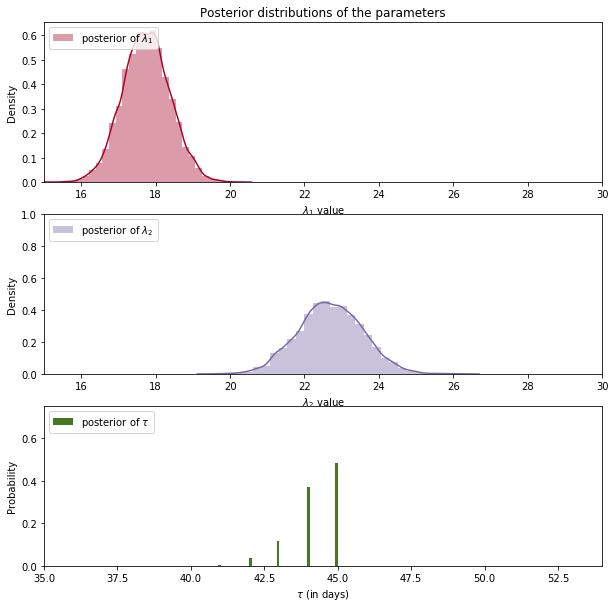

In [64]:
# histogram of the samples
f, ax = plt.subplots(figsize=(10, 10))


#plt sublot 1 declarartion (lambda 1)
ax = plt.subplot(311)
sns.distplot(lambda_1_samples, bins=30,label="posterior of $\lambda_1$", color="#A60628")
plt.legend(loc="upper left")

#declare main title
plt.title(r"""Posterior distributions of the parameters""")

plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("Density")
#lambda1 plot ends


#plt sublot 2 declarartion (lambda 2) setting similar to plot 1
ax = plt.subplot(312)
ax.set_autoscaley_on(False)
sns.distplot(lambda_2_samples, bins=30,label="posterior of $\lambda_2$", color="#7A68A6")
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")
plt.ylabel("Density")



#plt sublot 2 declarartion (lambda 2)
plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$", color="#467821",
         weights=w, rwidth=2.)
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("Probability");



Analysis based on our run.<br />
<br />
1) $\lambda_1$,$\lambda_2$ can be expected to hold values of about 18 and 23 respectivley. <br />
2) Based on lambda distributions we can comment that there were differences in the two groups, recall that we assigned $\lambda_1$ to group t < $\tau$, and we changed $\lambda_2$ accordingly. Both groups were introduced to similar exponential distibution's and resulting posterior distribution's for each group were different from one another. <br />
2)  Posetrior distribution of $\tau$ is discrete. As based on our assumptions prior to output. <br />
3) Day 45 has a 50% chance og showing behavioral changes.
